In [1]:
import pandas as pd
import numpy as np 
from numpy import random

data = pd.read_csv('data/result.csv')
data = data[52992:56992]
data

,time,outdoor_temp,zone_temp,occupancy,supply_temp,air_flow
52992,7/4/17 0:00,18.000000,23.613739,0,24.004024,0.733767
52993,7/4/17 0:05,18.000000,23.707526,0,25.097556,0.733767
52994,7/4/17 0:10,18.000000,23.609715,0,24.028751,0.733767
52995,7/4/17 0:15,18.000000,23.701950,0,25.087994,0.733767
52996,7/4/17 0:20,18.000000,23.813668,0,25.000012,0.733767
...,...,...,...,...,...,...
56987,7/17/17 20:55,26.083333,23.881448,1,23.657709,0.733767
56988,7/17/17 21:00,26.000000,23.882465,1,23.678341,0.733767
56989,7/17/17 21:05,25.583333,23.866141,0,23.765498,0.733767
56990,7/17/17 21:10,25.166667,23.845643,0,23.799238,0.733767


In [160]:
##Faults:
# 1. Offset Fault: x' = a + x + err
# 2. Gain Fault: x' = Bx+ err
# 3. Stuck at Fault: x' = a
# 4. Out-of-bound: x'<theta1 and x'>theta2

def simulateFault(sensedValues, params):
    end_fault_index = int(len(sensedValues) * 0.5)
    interval = end_fault_index/3
    BMS = []
    true_values = []
    BMS_final = []
    
    noise = random.rand(len(sensedValues)) * 0.5

    for i in range(0, len(sensedValues)):
        if i <= interval:
            a = params['constant']
            BMS.append(noise[i] + a + sensedValues[i])

        elif i > interval and i <= interval*2:
            B = params['coeff']
            BMS.append(noise[i] + B * sensedValues[i])

        elif i > interval*2 and i<= interval*3:
            a = params['stuck']
            BMS.append(a)

        else:
            BMS.append(noise[i] + sensedValues[i])

    for i in range(0, len(sensedValues)-2):
        temp = BMS[i:i+3]
        if i  <= interval:
            BMS_final.append(temp)
            true_values.append(sensedValues[i:i+3])

        elif i > interval and i <= interval*2:
            BMS_final.append(temp)
            true_values.append(sensedValues[i:i+3])


        elif i > interval*2 and i <= interval*3:
            BMS_final.append(temp)
            true_values.append(sensedValues[i:i+3])

        else:
            BMS_final.append(temp)
            true_values.append(sensedValues[i:i+3])
    return np.array(BMS_final), np.array(true_values)


In [161]:
def prepare_data(BMS, sensor_data):
    vectors = []
    end_fault_index = int(len(sensor_data) * 0.5)
    interval = end_fault_index/3
    for i in range(0, len(sensor_data)):
        temp = []
        for j in range(0,len(BMS[i])):
            temp.append([sensor_data[i][j],BMS[i][j]])
        vectors.append(temp)
    return vectors

In [162]:
def sample_vectors(vectors, classification, fault_rate):
    result_x = []
    
    end_fault_index = int(len(vectors) * fault_rate)
    for i in range(0, end_fault_index):
        fault = random.randint(0, int(len(vectors)*0.5))
        result_x.append(vectors[fault])
    for i in range(int(len(vectors)*0.5), len(vectors)):
        result_x.append(vectors[i])
        
    return result_x

In [181]:
def process_data(vectors):
    processed_data = []
    classification = []
    for i in range(0,len(vectors)):
        #print(vectors[i])
        if vectors[i][0][1] == vectors[i][1][1]:
            processed_data.append([1,1])
            classification.append(3)
        elif vectors[i][0][1] - vectors[i][0][0] > 0.5 and vectors[i][1][1] - vectors[i][1][0] > 0.5:
            slope = (vectors[i][0][1] - vectors[i][1][1])/(vectors[i][0][0]-vectors[i][1][0])
            if slope > 1.5 or slope < 0.5:
                processed_data.append([1,0])
                classification.append(2)
            else:
                processed_data.append([0,1])
                classification.append(1)
        else:
            classification.append(0)
            processed_data.append([0,0])
    return processed_data, classification

In [182]:
#Import svm model
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import recall_score
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler

rates = [0.1,0.2,0.3,0.4,0.5]

i = 0.1

acc = []
offset = []
gain = []
stuck = []

scaler = StandardScaler()

train_data = data[0:2640]
test_data = data[2640:4000]

supply_temp_train = train_data['supply_temp'].tolist()

stuck_val = random.choice(supply_temp_train)

BMS, sensor_reading = simulateFault(supply_temp_train, {'constant': -2, 'coeff': 1.05, 'stuck': stuck_val})

vectors = prepare_data(BMS,sensor_reading)
#print(vectors[0])
# print(vectors[1])

x_train, y_train = process_data(vectors)
# print(x_train[0])
# print(y_train[0])

x_train = np.array(x_train)
y_train = np.array(y_train)

#Create a svm Classifier
clf = svm.SVC(kernel='linear') # Linear Kernel

#Train the model using the training sets
clf.fit(x_train, y_train)

while i <= 0.5:
    supply_temp_test = test_data['supply_temp'].tolist()
    stuck_val = random.choice(supply_temp_test)
    #print(stuck_val)

    BMS, sensor_reading = simulateFault(supply_temp_test, {'constant': 3, 'coeff':1.25, 'stuck': stuck_val})

    x_test = prepare_data(BMS, sensor_reading)
    vectors = sample_vectors(x_test, y_test, i)
    x_test, y_test = process_data(vectors)
    #print(x_test[0])
    #print(y_test)
    x_test = np.array(x_test)
    y_test = np.array(y_test)
    
    y_pred = clf.predict(x_test)
    target_names = ['class 0', 'class 1', 'class 2', 'class 3']
    
    #target_names = ['class 0', 'class 1']
    #print('FOR rate: ',i)
    cnf_matrix = confusion_matrix(y_test, y_pred)
    print(confusion_matrix(y_test, y_pred))
    print(classification_report(y_test, y_pred, target_names=target_names))
    column_sum = cnf_matrix.sum(axis = 1)
    #print(column_sum)
    #acc.append(cnf_matrix[1][1] / column_sum[1] )
    offset.append(cnf_matrix[1][1] / column_sum[1] )
    gain.append(cnf_matrix[2][2] / column_sum[2])
    stuck.append(cnf_matrix[3][3] / column_sum[3])
        
    #print(acc)
    i = i + 0.1 


[[678   0   0   0]
 [  0  24   0   0]
 [  0   0  78   0]
 [  0   0   0  34]]
              precision    recall  f1-score   support

     class 0       1.00      1.00      1.00       678
     class 1       1.00      1.00      1.00        24
     class 2       1.00      1.00      1.00        78
     class 3       1.00      1.00      1.00        34

    accuracy                           1.00       814
   macro avg       1.00      1.00      1.00       814
weighted avg       1.00      1.00      1.00       814

[[678   0   0   0]
 [  0  54   0   0]
 [  0   0 121   0]
 [  0   0   0  97]]
              precision    recall  f1-score   support

     class 0       1.00      1.00      1.00       678
     class 1       1.00      1.00      1.00        54
     class 2       1.00      1.00      1.00       121
     class 3       1.00      1.00      1.00        97

    accuracy                           1.00       950
   macro avg       1.00      1.00      1.00       950
weighted avg       1.00      1.

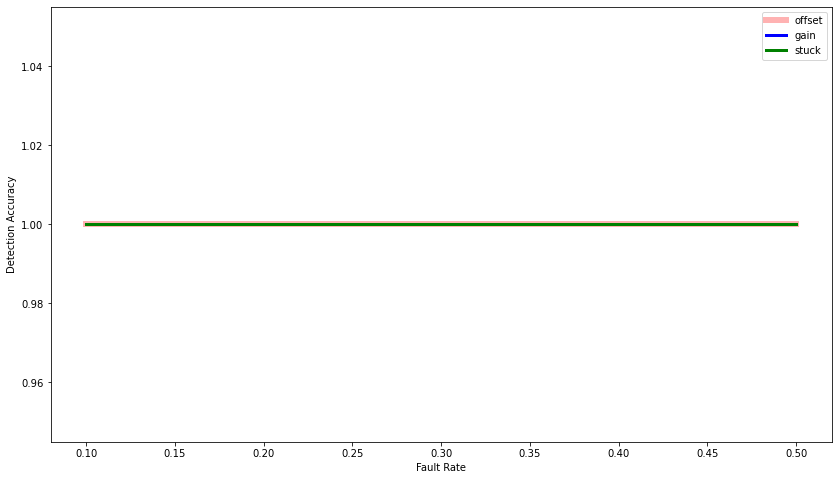

In [183]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
#ax.plot(rates, acc, "blue", linewidth=3, label = 'Acc')
ax.plot(rates, offset, "red", linewidth=6, label='offset', alpha = 0.3)
ax.plot(rates, gain, "blue", linewidth=3, label = 'gain')
ax.plot(rates, stuck, "green", linewidth=3, label = 'stuck',)
ax.set_ylabel('Detection Accuracy')
ax.set_xlabel('Fault Rate')
fig.set_size_inches(14, 8)
plt.legend()
plt.show()